# 0. Total Insight 정리

> 1. Gain, Losses 같은 변수들을 이진 변수로 바꾸고 회귀 돌렸던 6번 제출이 성능은 가장 좋게 나왔다.<br>
> 이를 우선 베이스 모델로 만들자.
> 2. 학습 데이터를 늘려서 Cross-val-score를 통해 검증하고 제출해보자.
> 3. 모델 스태킹을 사용한 모델 제출해보자.

In [1]:
# 기초 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기

In [2]:
# 데이터의 파일 경로 설정 및 파일 이름 확인
import os

path = os.getcwd() + '/data'
data_files = os.listdir(path)
print('Data files: ', data_files)

train_origin = pd.read_csv(path+'/train.csv')  # train 데이터 불러오기
test_origin = pd.read_csv(path+'/test.csv')    # test 데이터 불러오기
train_origin.shape, test_origin.shape    # 데이터 정보 확인

Data files:  ['sample_submission.csv', 'test.csv', 'train.csv']


((20000, 23), (10000, 22))

In [3]:
# 데이터 요약 정보 확인 함수 정의
def resumetable(df):
    print(f'Data Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': 'Feature'})
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values

    return summary

# 2. 전처리

In [4]:
# 전처리 전 원본 데이터 복사
train = train_origin.copy()
test = test_origin.copy()

In [5]:
# 'Gains', 'Losses', 'Dividends'를 이진 변수로 변환(값이 있으면 1, 없으면 0)
train['Gains'] = train['Gains'].apply(lambda x: 1 if x > 0 else 0)
train['Losses'] = train['Losses'].apply(lambda x: 1 if x > 0 else 0)
train['Dividends'] = train['Dividends'].apply(lambda x: 1 if x > 0 else 0)

In [6]:
# Isolation Forest를 이용한 이상치 제거
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, contamination=0.01, random_state=42)     # 이상치 비율 1%로 설정
clf.fit(train[['Income']])
outlier = clf.predict(train[['Income']])
train['Income_outlier'] = outlier

train = train[train['Income_outlier'] == 1]    # 이상치 제거
train = train.drop(columns=['Income_outlier'])    # 이상치 제거 후 컬럼 삭제

In [7]:
train.shape, test.shape

((19810, 23), (10000, 22))

# 3. Feature engineering

In [8]:
all_data = pd.concat([train, test], axis=0)    # train과 test 데이터 병합
all_data.drop('ID', axis=1, inplace=True)     # ID는 인코딩할 필요 없으므로 제외
all_data.shape

(29810, 22)

In [9]:
all_data.shape

(29810, 22)

In [10]:
category = ['Gender', 'Education_Status', 'Employment_Status', 'Industry_Status', 'Occupation_Status', 'Race', 'Hispanic_Origin', 'Martial_Status', 'Household_Status', 'Household_Summary', 'Citizenship', 'Birth_Country', 'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status', 'Income_Status']
numeric = ['Age', 'Working_Week (Yearly)', 'Gains', 'Losses', 'Dividends']

In [11]:
# 수치형 변수 StandardScaler 적용
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_data[numeric] = scaler.fit_transform(all_data[numeric])


# 범주형 변수 인코딩(OHE)
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder()
encoded_data = OHE.fit_transform(all_data[category]).toarray()    # OneHotEncoder를 사용하여 범주형 변수 인코딩
encoded_data = pd.DataFrame(encoded_data, columns=OHE.get_feature_names_out(category))    # 인코딩된 데이터를 DataFrame으로 변환

In [12]:
# 다시 train, test 데이터 분할
train = all_data[:len(train)].reset_index(drop=True)
test = all_data[len(train):].reset_index(drop=True)

train_encoded = encoded_data[:len(train)].reset_index(drop=True)
test_encoded = encoded_data[len(train):].reset_index(drop=True)

In [13]:
# 기존의 범주형 변수 제거 후 인코딩된 범주형 변수 추가
train = train.drop(category, axis=1)
train = pd.concat([train, train_encoded], axis=1)

test = test.drop(category, axis=1)
test = pd.concat([test, test_encoded], axis=1)

In [14]:
train.shape, test.shape

((19810, 277), (10000, 277))

> Data downcasting

In [15]:
# downcast 함수 정의
def downcast(df, verbose=True):     # verbose 옵션 추가: (True)인 경우 몇 퍼센트 압축됐는지 출력
    start_mem = df.memory_usage().sum() / 1024**2   # 초기 메모리 사용량
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print(f'{(100*(start_mem - end_mem) / start_mem):.1f}% 압축됨')

    return df

In [16]:
# 메모리 사용량 최적화
train = downcast(train)
test = downcast(test)

86.8% 압축됨
86.7% 압축됨


# 4. 시험 모델링

In [17]:
# train, validation 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train.drop('Income', axis=1), train['Income'], test_size=0.2, random_state=42)

In [18]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((15848, 276), (3962, 276), (15848,), (3962,))

In [19]:
# 성능지표 정의: RMSE
from sklearn.metrics import mean_squared_error

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### (1) 기존의 best 모델

In [20]:
# LightGBM 모델
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val)

params = {
    'num_iterations': 300,      # 반복 수행하려는 트리의 개수 (너무 크면 오버피팅 발생)
    'max_depth': 10,            #* 트리의 최대 깊이 (너무 크면 오버피팅 발생)   # 보통 3~12(가장 민감하므로 먼저 튜닝해야할 값) # lightgbm처럼 leaf-wise로 학습하는 경우 끝까지(-1)도 괜찮다고 한다.
    # 'boosting_type' = 'gbdt'  # 부스팅 타입 (gbdt: Gradient Boosting Decision Tree, rf: RandomForest)
    # 'min_data_in_leaf' = 30   #* 한 리프의 최소 데이터 수 (클수록 오버피팅 방지, 너무 크면 과소적합)
    'objective': 'regression',  #* 수치예측이면 regression, 이진분류이면 binary, 다중분류이면 multiclass
    'metric': 'rmse',           # 성능지표 (rmse: Root Mean Squared Error)
    'num_leaves': 255,          #* 하나의 트리가 가질 수 있는 최대 리프 수 (2번째로 민감. max_depth와 함께 튜닝)
    'learning_rate': 0.01,      # 부스팅 스탭 반복할 때 학습률(0~1) #튜닝시 0.1~0.3, 최종 모형은 0.05 이하
    'force_col_wise': True,     # 데이터가 많을 때 속도 향상
    'random_state': 42
}

lgb_model = lgb.train(params=params,
                    train_set = lgb_train,
                    num_boost_round=500,
                    valid_sets=[lgb_train, lgb_val])

c:\Users\prohe\anaconda3\envs\py38\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 15848, number of used features: 215
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 520.061522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [21]:
# 성능 평가
from sklearn.metrics import mean_squared_error

# 훈련 데이터에 대한 예측값
y_pred = lgb_model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f'RMSE: {rmse:.4f}')

y_pred = lgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'RMSE: {rmse:.4f}')

RMSE: 415.4335
RMSE: 453.6204


### (2) 훈련 데이터 늘리기

In [22]:
train.shape, test.shape

((19810, 277), (10000, 277))

In [150]:
# train 데이터 분할
X_train, y_train = train.drop('Income', axis=1), train['Income']

In [54]:
# LightGBM 모델
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(n_estimators=300, max_depth=10, metric = 'rmse', num_leaves = 255, learning_rate = 0.01,
                    min_child_samples = 30, force_col_wise = True, random_state = 42, objective='regression')
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 19810, number of used features: 199
[LightGBM] [Info] Start training from score 519.593690
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMRegressor(force_col_wise=True, learning_rate=0.01, max_depth=10,
              metric='rmse', min_child_samples=30, n_estimators=300,
              num_leaves=255, objective='regression', random_state=42)

In [55]:
# 성능 평가

# 훈련 데이터에 대한 예측값
y_pred = lgbm.predict(X_train)
rmse = RMSE(y_train, y_pred)
print(f'RMSE: {rmse:.4f}')

RMSE: 423.5570


In [56]:
# cross_val_score를 이용한 교차검증
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lgbm, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
scores = -scores
print(scores)
print(f'평균 RMSE: {scores.mean():.4f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 15848, number of used features: 185
[LightGBM] [Info] Start training from score 521.570482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

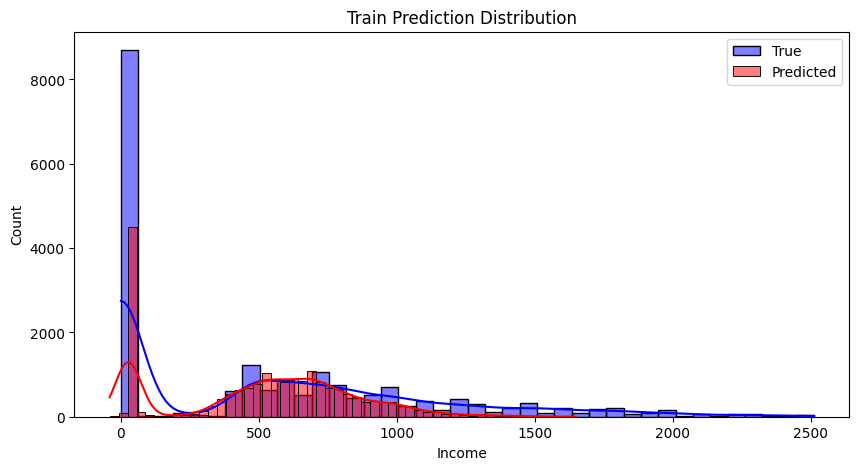

In [57]:
# train 예측에 대한 분포
plt.figure(figsize=(10, 5))
sns.histplot(y_train, kde=True, color='blue', label='True')
sns.histplot(y_pred, kde=True, color='red', label='Predicted')
plt.legend()
plt.title('Train Prediction Distribution')
plt.show()

### (3) 모델 Stacking

In [62]:
# train, validation 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train.drop('Income', axis=1), train['Income'], test_size=0.2, random_state=42)

In [64]:
# RandomForest 모델 테스트
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=300, max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [66]:
# 성능 평가
y_pred = rf.predict(X_train)
rmse = RMSE(y_train, y_pred)
print(f'RMSE: {rmse:.4f}')

y_pred = rf.predict(X_val)
rmse = RMSE(y_val, y_pred)
print(f'RMSE: {rmse:.4f}')

RMSE: 423.2907
RMSE: 462.8391


In [72]:
# 표본이 다르게 샘플링 된 lightgbm 모델 테스트
from sklearn.model_selection import train_test_split

t_lgbm = LGBMRegressor(n_estimators=300, max_depth=10, metric = 'rmse', num_leaves = 255, learning_rate = 0.01,
                    min_child_samples = 30, force_col_wise = True, random_state = 0, objective='regression')
t_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 15848, number of used features: 185
[LightGBM] [Info] Start training from score 520.061522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMRegressor(force_col_wise=True, learning_rate=0.01, max_depth=10,
              metric='rmse', min_child_samples=30, n_estimators=300,
              num_leaves=255, objective='regression', random_state=0)

In [73]:
# 성능 평가
y_pred = t_lgbm.predict(X_train)
rmse = RMSE(y_train, y_pred)
print(f'RMSE: {rmse:.4f}')

y_pred = t_lgbm.predict(X_val)
rmse = RMSE(y_val, y_pred)
print(f'RMSE: {rmse:.4f}')

RMSE: 420.4694
RMSE: 454.1272


#### [1] 직접 building

In [175]:
train1 = rf.predict(X_train)
train2 = lgbm.predict(X_train)
train3 = t_lgbm.predict(X_train)

In [176]:
train1.shape, train2.shape, train3.shape

((19810,), (19810,), (19810,))

In [177]:
stack_rf = RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)
stack_rf.fit(np.array([train1, train2, train3]).T, y_train)

RandomForestRegressor(max_depth=5, n_estimators=500, n_jobs=-1, random_state=42)

In [178]:
stack_lgbm = LGBMRegressor(n_estimators=500, max_depth=5, metric = 'rmse', num_leaves = 127, learning_rate = 0.02,
                    min_child_samples = 30, force_col_wise = True, random_state = 42, objective='regression')

stack_lgbm.fit(np.array([train1, train2, train3]).T, y_train)

[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 19810, number of used features: 3
[LightGBM] [Info] Start training from score 519.593690
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMRegressor(force_col_wise=True, learning_rate=0.02, max_depth=5,
              metric='rmse', min_child_samples=30, n_estimators=500,
              num_leaves=127, objective='regression', random_state=42)

In [179]:
# stack_rf train set 성능 평가
stack_rf_pred = stack_rf.predict(np.array([train1, train2, train3]).T)
rmse = RMSE(y_train, stack_rf_pred)
print(f'RMSE: {rmse:.4f}')

RMSE: 406.8482


In [180]:
# cross_val_score를 이용한 교차검증
from sklearn.model_selection import cross_val_score

scores = cross_val_score(stack_rf, np.array([train1, train2, train3]).T, y_train, cv=5, scoring='neg_root_mean_squared_error')
scores = -scores
print(scores)
print(f'평균 RMSE: {scores.mean():.4f}')

[415.83764415 420.51115819 409.29813196 404.86089827 414.90385055]
평균 RMSE: 413.0823


In [181]:
# stack_lgbm train set 성능 평가
stack_lgbm_pred = stack_lgbm.predict(np.array([train1, train2, train3]).T)
rmse = RMSE(y_train, stack_lgbm_pred)
print(f'RMSE: {rmse:.4f}')

RMSE: 396.5232


In [182]:
# cross_val_score를 이용한 교차검증
from sklearn.model_selection import cross_val_score

scores = cross_val_score(stack_lgbm, np.array([train1, train2, train3]).T, y_train, cv=5, scoring='neg_root_mean_squared_error')
scores = -scores
print(scores)
print(f'평균 RMSE: {scores.mean():.4f}')

[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 15848, number of used features: 3
[LightGBM] [Info] Start training from score 521.570482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [183]:
# test 셋에 대한 예측값
test1 = rf.predict(test)
test2 = lgbm.predict(test)
test3 = t_lgbm.predict(test)

stack_rf_pred = stack_rf.predict(np.array([test1, test2, test3]).T)
stack_rf_pred

array([2.31115659e-02, 2.31115659e-02, 3.35682557e+02, ...,
       3.34175447e+02, 2.31115659e-02, 5.73216767e+02])

#### [2] StackingTransformer 사용

In [160]:
# 본격적 모델 stacking
from vecstack import StackingTransformer

estimators = [
    ('RandomForest', RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)),
    ('LightGBM1', LGBMRegressor(n_estimators=400, max_depth=10, metric = 'rmse', num_leaves = 255, learning_rate = 0.01, min_child_samples = 30, force_col_wise = True, random_state = 42, objective='regression')),
    ('LightGBM2', LGBMRegressor(n_estimators=400, max_depth=10, metric = 'rmse', num_leaves = 255, learning_rate = 0.01, min_child_samples = 30, force_col_wise = True, random_state = 0, objective='regression')),
    ('LightGBM3', LGBMRegressor(n_estimators=400, max_depth=10, metric = 'rmse', num_leaves = 255, learning_rate = 0.01, min_child_samples = 30, force_col_wise = True, random_state = 10, objective='regression')),
    ('LightGBM4', LGBMRegressor(n_estimators=400, max_depth=10, metric = 'rmse', num_leaves = 255, learning_rate = 0.01, min_child_samples = 30, force_col_wise = True, random_state = 29, objective='regression'))
]

In [162]:
# Initialize StackingTransformer

stack = StackingTransformer(estimators,
                            regression = True, 
                            metric = RMSE,
                            n_folds = 5, stratified = False, shuffle = True, 
                            random_state = 42, verbose = 2)

In [163]:
# Fit
stack = stack.fit(X_train, y_train)

task:         [regression]
metric:       [RMSE]
variant:      [A]
n_estimators: [5]

estimator  0: [RandomForest: RandomForestRegressor]
    fold  0:  [475.47008237]
    fold  1:  [473.79424077]
    fold  2:  [463.24372075]
    fold  3:  [469.52867771]
    fold  4:  [453.82251303]
    ----
    MEAN:     [467.17184692] + [7.89818148]

estimator  1: [LightGBM1: LGBMRegressor]
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 15848, number of used features: 185
[LightGBM] [Info] Start training from score 520.061522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [167]:
# Get your stacked features
S_train = stack.transform(X_train)
S_test = stack.transform(test)

Train set was detected.
Transforming...

estimator  0: [RandomForest: RandomForestRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  1: [LightGBM1: LGBMRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  2: [LightGBM2: LGBMRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  3: [LightGBM3: LGBMRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    ----
    DONE

estimator  4: [LightGBM4: LGBMRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done


In [168]:
# Use 2nd level estimator with stacked features

model = LGBMRegressor(n_estimators=500, max_depth=8, metric = 'rmse', num_leaves = 255, learning_rate = 0.01, min_child_samples = 50, force_col_wise = True, random_state = 42, objective='regression')
model = model.fit(S_train, y_train) 

y_pred = model.predict(S_test) 

[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 19810, number of used features: 5
[LightGBM] [Info] Start training from score 519.593690
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [169]:
y_pred

array([  4.07822245,   4.07822245, 403.82377753, ..., 395.51136266,
         4.07822245, 571.26056913])

# 제출할 때

In [185]:
# 제출용 데이터 확인
submission = pd.read_csv(path+'/sample_submission.csv')
submission.head()

,ID,Income
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [ ]:
# test 데이터에 대한 예측값
test.drop('Income', axis=1, inplace=True)

test_pred = lgbm.predict(test)
test_pred

In [186]:
# 제출용 파일 생성
submission['Income'] = stack_rf_pred
submission.to_csv('submission10.csv', index=False)